<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/31_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM + CNN 평균 앙상블 방식 테슬라 주가 예측 (슬라이딩 + 롤링 윈도우) ㅡ평균방식

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


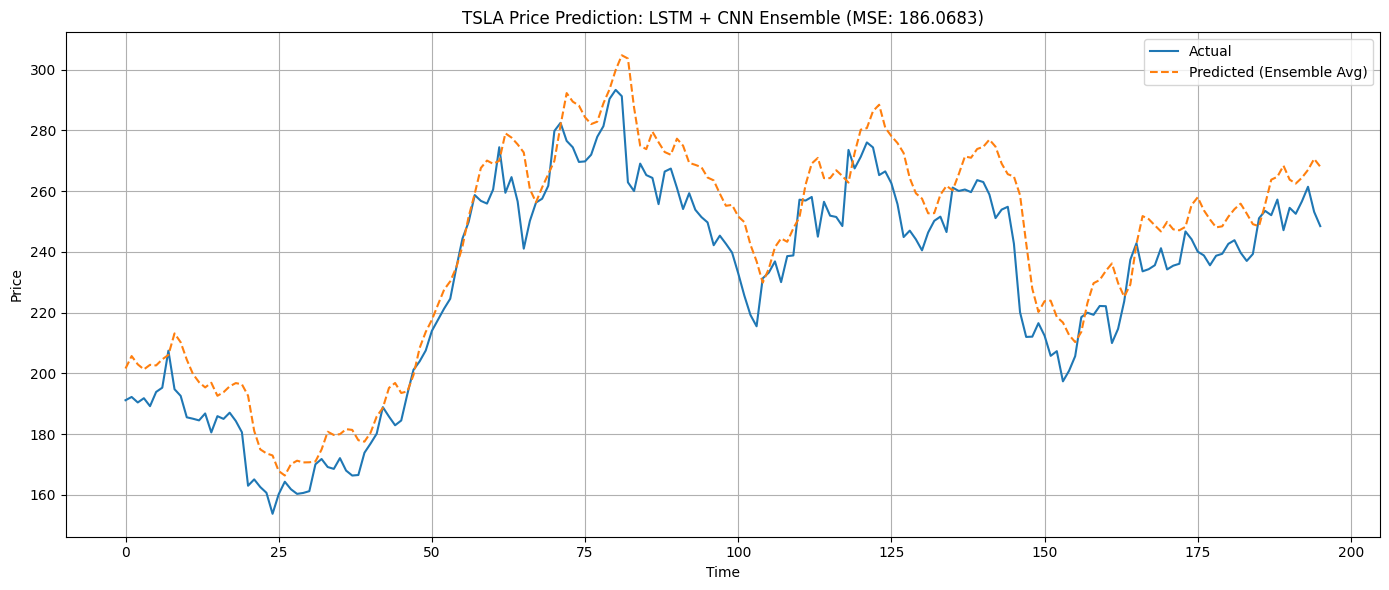

In [1]:
# 필요한 라이브러리 설치 (Colab에서만 실행)
# !pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Average
from tensorflow.keras.optimizers import Adam

# 1. 데이터 수집
df = yf.download("TSLA", start="2020-01-01", end="2024-01-01")[['Close']].dropna()

# 2. 정규화
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# 3. 슬라이딩 윈도우
def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_dataset(df['Close'].values, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# 4. 데이터 분할
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. 모델 정의 (LSTM + CNN 앙상블)
input_layer = Input(shape=(window_size, 1))

lstm_out = LSTM(64)(input_layer)
cnn_out = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
cnn_out = Flatten()(cnn_out)

# 차원 정합
lstm_out = Dense(64)(lstm_out)
cnn_out = Dense(64)(cnn_out)

merged = Average()([lstm_out, cnn_out])
output = Dense(1)(merged)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 6. 학습
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

# 7. 예측 및 역변환
pred = model.predict(X_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 8. 성능 평가 및 시각화
mse = mean_squared_error(y_test_inv, pred_inv)
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_inv, label='Predicted (Ensemble Avg)', linestyle='--')
plt.title(f"TSLA Price Prediction: LSTM + CNN Ensemble (MSE: {mse:.4f})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM + CNN 앙상블 (Average, Add, Concatenate 비교)

Average: 단순 평균으로 병합.

Add: 동일한 차원끼리의 합산.

Concatenate: 특성을 이어붙여서 정보 손실 없이 전달.

[*********************100%***********************]  1 of 1 completed


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


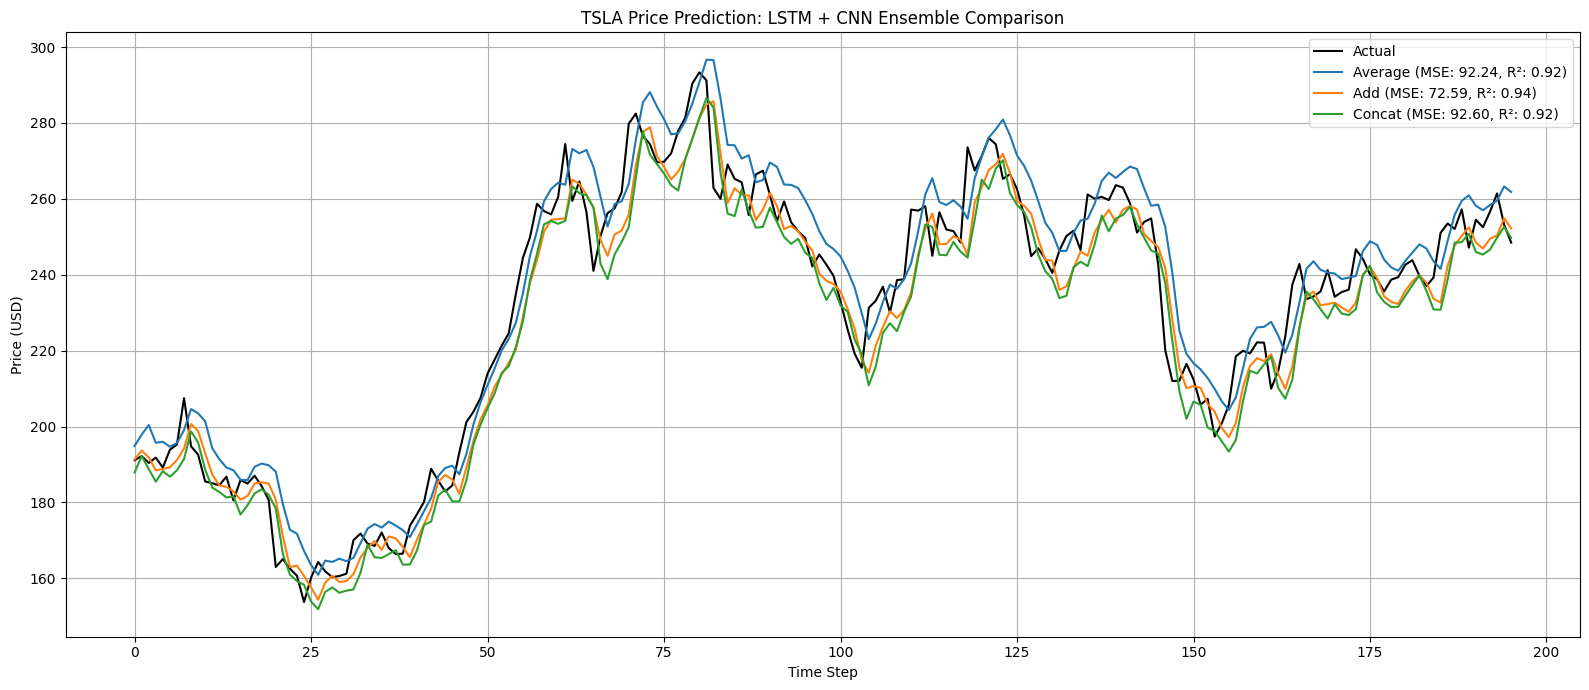

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Average, Add, concatenate
from tensorflow.keras.optimizers import Adam

# 1. 데이터 수집
df = yf.download("TSLA", start="2020-01-01", end="2024-01-01")[['Close']].dropna()

# 2. 정규화
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# 3. 슬라이딩 윈도우 함수
def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_dataset(df['Close'].values, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# 4. 학습 / 테스트 분할
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. 모델 생성 함수
def build_model(merge_type='average'):
    input_layer = Input(shape=(window_size, 1))
    lstm_out = LSTM(64)(input_layer)
    cnn_out = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Flatten()(cnn_out)

    # 차원 정합을 위한 Dense
    lstm_out = Dense(64)(lstm_out)
    cnn_out = Dense(64)(cnn_out)

    if merge_type == 'average':
        merged = Average()([lstm_out, cnn_out])
    elif merge_type == 'add':
        merged = Add()([lstm_out, cnn_out])
    elif merge_type == 'concat':
        merged = concatenate([lstm_out, cnn_out])
    else:
        raise ValueError("Invalid merge_type")

    output = Dense(1)(merged)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 6. 훈련 및 평가
results = {}
for merge_type in ['average', 'add', 'concat']:
    model = build_model(merge_type)
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
    pred = model.predict(X_test)
    pred_inv = scaler.inverse_transform(pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_test_inv, pred_inv)
    r2 = r2_score(y_test_inv, pred_inv)
    results[merge_type] = {'pred': pred_inv, 'mse': mse, 'r2': r2}

# 7. 시각화
plt.figure(figsize=(16, 7))
plt.plot(y_test_inv, label='Actual', color='black')
for method, result in results.items():
    plt.plot(result['pred'], label=f"{method.title()} (MSE: {result['mse']:.2f}, R²: {result['r2']:.2f})")
plt.title("TSLA Price Prediction: LSTM + CNN Ensemble Comparison")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# TSLA 주가 예측: LSTM + CNN 앙상블 (Average, Add, Concatenate) + LSTM 단독 + CNN 단독


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


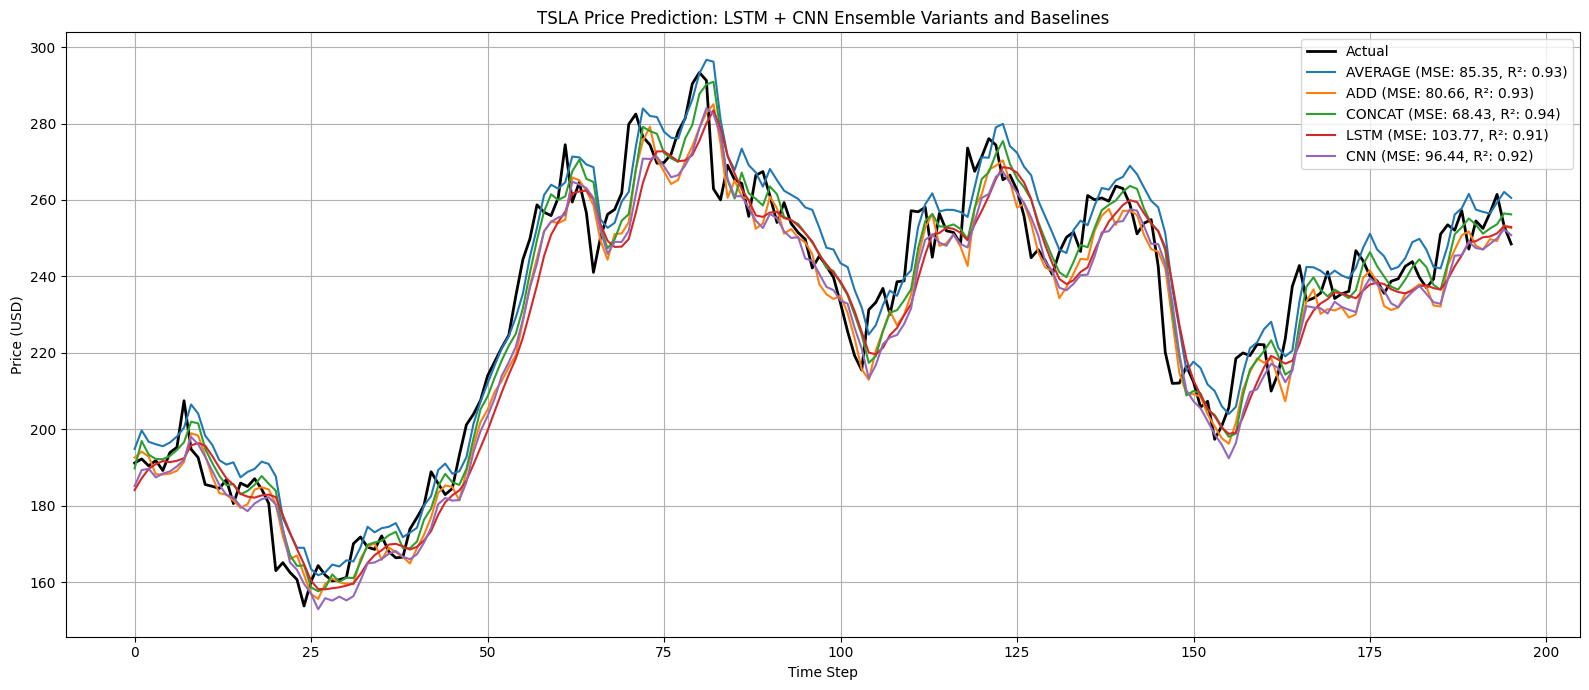

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Average, Add, concatenate
from tensorflow.keras.optimizers import Adam

# 1. 데이터 수집
df = yf.download("TSLA", start="2020-01-01", end="2024-01-01")[['Close']].dropna()

# 2. 정규화
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# 3. 슬라이딩 윈도우
def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_dataset(df['Close'].values, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# 4. 학습/테스트 분할
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. 모델 정의
def build_ensemble_model(merge_type='average'):
    input_layer = Input(shape=(window_size, 1))
    lstm_out = LSTM(64)(input_layer)
    cnn_out = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Flatten()(cnn_out)
    lstm_out = Dense(64)(lstm_out)
    cnn_out = Dense(64)(cnn_out)

    if merge_type == 'average':
        merged = Average()([lstm_out, cnn_out])
    elif merge_type == 'add':
        merged = Add()([lstm_out, cnn_out])
    elif merge_type == 'concat':
        merged = concatenate([lstm_out, cnn_out])
    else:
        raise ValueError("Invalid merge_type")

    #  Dense(1) 출력 레이어에서 예측값 스케일을 조절할 수 있습니다.
    output = Dense(1)(merged)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_lstm_model():
    model = Sequential([
        LSTM(64, input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_model():
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 6. 훈련 및 예측
results = {}
models = {
    'average': build_ensemble_model('average'),
    'add': build_ensemble_model('add'),
    'concat': build_ensemble_model('concat'),
    'lstm': build_lstm_model(),
    'cnn': build_cnn_model()
}

for name, model in models.items():
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
    pred = model.predict(X_test)
    pred_inv = scaler.inverse_transform(pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_test_inv, pred_inv)
    r2 = r2_score(y_test_inv, pred_inv)
    results[name] = {'pred': pred_inv.flatten(), 'mse': mse, 'r2': r2}

# 7. 시각화
plt.figure(figsize=(16, 7))
plt.plot(y_test_inv, label='Actual', color='black', linewidth=2)
for name, res in results.items():
    plt.plot(res['pred'], label=f"{name.upper()} (MSE: {res['mse']:.2f}, R²: {res['r2']:.2f})")
plt.title("TSLA Price Prediction: LSTM + CNN Ensemble Variants and Baselines")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
